# Chapter 2: Introduction to Dask

Now that we have a foundation to understand distributed computing, let's discuss Dask - one of the frameworks that can allow data scientists to take advantage of this infrastructure.

**Dask is an open-source framework that enables parallelization of Python code.** This can be applied to all kinds of Python use cases, not just machine learning. Dask is designed to work well on single-machine setups and on multi-machine clusters. You can use Dask with pandas, NumPy, scikit-learn, and other Python libraries.

## Lazy Evaluation

An important key concept to understanding Dask is the idea of delayed or "lazy" evaluation. Viewers who have used other systems for parallelizing code may find this familiar.

**Delaying a task can queue up a set of transformations or calculations so that it's ready to run later, in parallel.** Dask won't evaluate the requested computations until explicitly told to. This differs from other kinds of functions, which compute instantly upon being called. 

Many very common and handy functions are ported to be native in Dask, which means they will be lazy (delayed computation) without you ever having to even ask.

However, sometimes you will have complicated custom code that is written in pandas, scikit-learn, or even base python, that isn't natively available in Dask. Other times, you may just not have the time or energy to refactor your code into Dask, if edits are needed to take advantage of native Dask elements. If this is the case, you can decorate your functions with `@dask.delayed`, which will manually establish that the function should be lazy, and not evaluate until you tell it. Let's work through an example!

### Example 1

In [4]:
def exponent(x, y):
    '''Define a basic function.'''
    return x ** y

# Function returns result immediately when called
exponent(4, 5)

1024

In [5]:
import dask

@dask.delayed
def lazy_exponent(x, y):
    '''Define a lazily evaluating function'''
    return x ** y

# Function returns a delayed object, not computation
lazy_exponent(4, 5)

Delayed('lazy_exponent-df424e57-ca52-425d-88a9-fa8ddddd51d7')

In [6]:
# This will now return the computation
lazy_exponent(4, 5).compute()

1024

### Example 2

We can take this knowledge and expand it - because our lazy function returns an object, we can assign it and then chain it together in different ways later.

Here we return a delayed value from the first function, and call it `x`. Then we pass `x` to the function a second time, and call it `y`. Finally, we multiply `x` and `y` to produce `z`.

In [7]:
x = lazy_exponent(4, 5)
y = lazy_exponent(x, 2)
z = x * y
z

Delayed('mul-0a72bc18102ea898008ad9168159cf3e')

We can use the handy `.visualize()` method to see all the tasks we have lined up, and understand how Dask is interpreting it. 

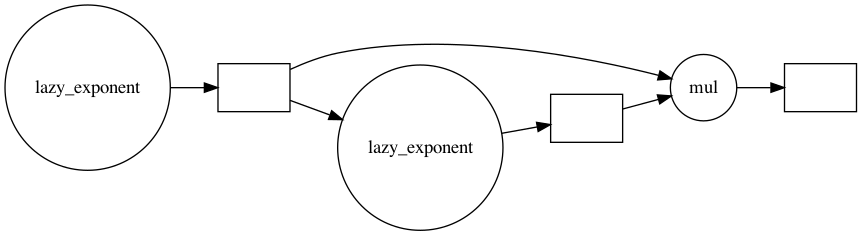

In [9]:
z.visualize(rankdir="LR")

Finally, we can just use `.compute()` again on `z` only, which kicks off all the computations that are lazy in this graph.

In [10]:
z.compute()

1073741824

## Native Dask Functions

You can accomplish a great deal just using `@dask.delayed` in your preexisting code. However, the Dask framework makes it even easier by having a lot of functionalities you find in PyData libraries natively supported.

In short, a function you use in pandas that just works serially has been adapted by Dask developers to work across distributed data storage or computation on a cluster.

A good example is the **Dask Dataframe**. Imagine we have the same data for a number of years, and we'd like to load that all at once. We can do that easily with Dask, and the API is very much like the pandas API. A Dask Dataframe contains a number of pandas Dataframes, which are distributed across your cluster.

<img src="img/daskdf.png" alt="diagram1" width="700"/>

## Persist vs Compute

Lots of new users of Dask find the `.persist()` and `.compute()` processes confusing. This is understandable! But the answer is not as hard as you might think.

First, remember we have several machines working for us right now. We have our Jupyter instance right here running on one, and then our cluster of worker machines also.


If we use `.compute()`, we are asking Dask to take all the computations and adjustments to the data that we have queued up, and run them, and bring it all to the surface here, in Jupyter. That means if it was distributed we want to convert it into a local object here and now. If it's a Dask Dataframe, when we call `.compute()`, we're saying "Run the transformations we've queued, and convert this into a pandas dataframe immediately." If our data is too big to be held in local pandas memory, this can be a disaster! But if it is small, then we might be fine.



If we use `.persist()`, we are asking Dask to take all the computations and adjustments to the data that we have queued up, and run them, but then the object is going to remain distributed and will live on the cluster, not on the Jupyter instance. So when we do this with a Dask Dataframe, we are telling our cluster "Run the transformations we've queued, and leave this as a distributed Dask Dataframe."

So, if you want to process all the delayed tasks you've applied to a Dask object, either of these methods will do it. **The difference is where your object will live at the end.**

## Communicating with a Cluster

To make this all work in a distributed fashion, we need to understand how we send instructions to our cluster. When we use the `@dask.delayed` decorator, we queue up some work and put it in a list, ready to be run. So how do we send it to the workers and explain what we want them to do?

We use the `distributed` module from Dask to make this work. We connect to our cluster (we'll use the Saturn libraries to see this in practice) and then we'll use some commands to send instructions.

In [ ]:
from dask_saturn import SaturnCluster
from dask.distributed import Client

cluster = SaturnCluster(
    scheduler_size='medium',
    worker_size='xlarge',
    n_workers=3,
    nthreads=3,
)
client = Client(cluster)

### Sending Tasks

The object `client` is our handle in to the cluster, for whatever we want to send! We will use a few processes to do this communication: `.submit()` and `.map()`.

`.submit()` lets us send one task to the cluster, to be run once on whatever worker is free. `.map()` lets us send lots of tasks, which will be disseminated to workers in the most efficient way. There's also `.run()` which you can use to send one task to EVERY worker on the cluster simultaneously. This is only used for small utility tasks, however - like installing a library or collecting diagnostics. For example, you can use `.map()` in this way:

```futures = client.map(function, list_of_inputs)```

This takes our function, maps it over all the inputs, and then these tasks are distributed to the cluster workers. Note: they still won't actually compute yet! Our function is delayed, so it's just out there on the workers ready to go when we say. futures is a list of pointers to these tasks that we can use to send that command.

### Processing Results

We have one more step before we use `.compute()`, which is `.gather()`. This creates one more instruction to be included in this big delayed job we're establishing: retrieving the results from all of our jobs. It's going to sit tight as well until we finally say `.compute()`.

```futures_gathered = client.gather(futures)```

It may help to think of all the work as instructions in a list. We have so far told our cluster: "map our delayed function over this list of inputs, and pass the resulting tasks to the workers", "Gather up the results of those tasks, and bring them back". But the one thing we haven't said is "Ok, now begin to process all these instructions"! That's what `.compute()` will do. For us this looks like:

```futures_computed = client.compute(futures_gathered, sync=False)```